In [1]:
# from mat4py import loadmat
from scipy.io import loadmat
from pymatreader import read_mat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
subjects = read_mat("subjectData.mat")

In [45]:
class Data:
    def __init__(self, dataObj):
        self.subject1 = Subject(dataObj['subjectData']["preON"][0], dataObj['subjectData']["postON"][0], "Subject 1")
        self.subject2 = Subject(dataObj['subjectData']["preON"][1], dataObj['subjectData']["postON"][1], "Subject 2")
        
class Run:
    def __init__(self, eeg, header, fs):
        self.raw_eeg = np.array(eeg)
        
        trig_type = header["triggers"]["TYP"]
        trig_pos = header["triggers"]["POS"]
        
        num_trials = 0
        num_hits = 0
        num_misses = 0
        num_timeouts = 0

        trials = []
        for i, t_type in enumerate(trig_type):
            if t_type == 1000:
                num_trials += 1
                trial = {}
                trial["rest_start"] = trig_pos[i]
            elif t_type == 786:
                trial["fixation_start"] = trig_pos[i]
            elif (t_type == 769):
                trial["cue_start"] = trig_pos[i]
                trial["hand"] = "right"
            elif (t_type == 770):
                trial["cue_start"] = trig_pos[i]
                trial["hand"] = "left"
            elif (t_type == 7691) or (t_type == 7701):
                trial["execution_start"] = trig_pos[i]
            elif (t_type == 7692) or (t_type == 7702):
                trial["end"] = trig_pos[i]
                seconds = (trig_pos[i] - trial["execution_start"]) / fs
                if seconds > 7.0:
                    trial["fail_type"] = "timeout"
                    num_timeouts += 1
                else:
                    trial["fail_type"] = "miss"
                    num_misses += 1
                trial["hit"] = False
                trials.append(trial)
            elif (t_type == 7693) or (t_type == 7703):
                trial["end"] = trig_pos[i]
                trial["hit"] = True
                num_hits += 1
                
                trial["fail_type"] = "N/A"
                trials.append(trial)

        self.run_TOP = num_timeouts / num_trials
        self.run_CDA = num_hits / (num_hits + num_misses)
        self.trials = trials

class Subject:
    def __init__(self, preON, postON, subname):
        self.name = subname
        self.fs = preON['header'][0]["fs"]
        self.eegLabels = preON['header'][0]["eegLabels"]
        #not sure how to use eegLocs, it's kinda gross looking
        self.eegLocs = preON['header'][0]["eegLocs"]
        
        self.pre_stim_runs = {}
        self.post_stim_runs = {}
        
        runs = ["run1", "run2", "run3"]
        for i, run in enumerate(runs):
            self.pre_stim_runs[run] = Run(preON['eeg'][i], preON['header'][i], self.fs)
            self.post_stim_runs[run] = Run(postON['eeg'][i], postON['header'][i], self.fs)
            
    def print_struct(self):
        print("Stored in Selected Subject::")
        print(f"fs: {self.fs}")
        print(f"EEG Labels: {self.eegLabels}")
        print(f"Number of runs pre-stimulation: {len(self.pre_stim_runs)}")
        print(f"Number of runs pre-stimulation: {len(self.pre_stim_runs)}")
        runs = ["run1", "run2", "run3"]
        print("Pre-Stimulation:")
        for i, run in enumerate(runs):
            print(f"    Data shape: {self.pre_stim_runs[run].raw_eeg.shape}, number of trials: {len(self.pre_stim_runs[run].trials)}")
        print("Post-Stimulation:")
        for i, run in enumerate(runs):
            print(f"    Data shape: {self.post_stim_runs[run].raw_eeg.shape}, number of trials: {len(self.pre_stim_runs[run].trials)}")

    def plot_command_delivery_accuracy(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(self.name + " Command Delivery Accuracy")

        pre_CDAs = []
        post_CDAs = []

        runs = ["run1", "run2", "run3"]
        for i, run in enumerate(runs):
            pre_CDAs.append(self.pre_stim_runs[run].run_CDA)
            post_CDAs.append(self.post_stim_runs[run].run_CDA)

        if self.name == "Subject 1":
            ax1.bar([1,2,3], pre_CDAs)
            ax2.bar([1,2,3], post_CDAs)
        elif self.name == "Subject 2":
            ax1.bar([1,2,3], pre_CDAs, color ='orange')
            ax2.bar([1,2,3], post_CDAs, color='orange')

        ax1.set_title("Pre-Stimulation")
        ax2.set_title("Post-Stimulation")
        fig.supxlabel('Run')
        fig.supylabel('Accuracy (%/100)')

    def plot_timeout_pct(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(self.name + " Timeout Percent")

        pre_TOPs = []
        post_TOPs = []

        runs = ["run1", "run2", "run3"]
        for i, run in enumerate(runs):
            pre_TOPs.append(self.pre_stim_runs[run].run_TOP)
            post_TOPs.append(self.post_stim_runs[run].run_TOP)

        if self.name == "Subject 1":
            ax1.bar([1,2,3], pre_TOPs)
            ax2.bar([1,2,3], post_TOPs)
        elif self.name == "Subject 2":
            ax1.bar([1,2,3], pre_TOPs, color ='orange')
            ax2.bar([1,2,3], post_TOPs, color='orange')

        ax1.set_title("Pre-Stimulation")
        ax2.set_title("Post-Stimulation")
        fig.supxlabel('Run')
        fig.supylabel('Timeout Rate (%/100)')

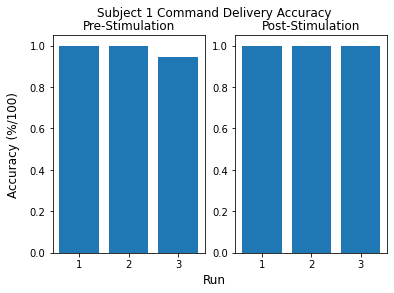

In [46]:
d = Data(subjects)
d.subject1.plot_command_delivery_accuracy()

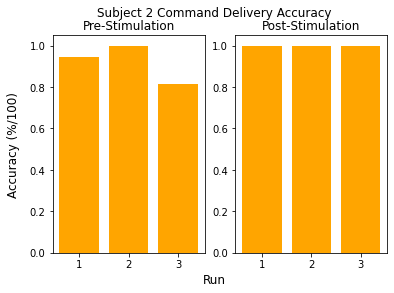

In [47]:
d = Data(subjects)
d.subject2.plot_command_delivery_accuracy()

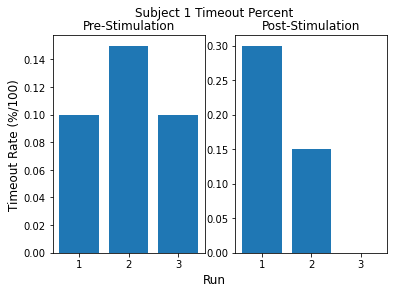

In [48]:
d = Data(subjects)
d.subject1.plot_timeout_pct()

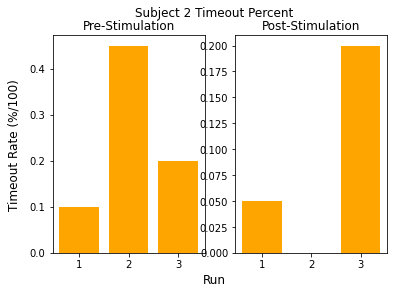

In [49]:
d = Data(subjects)
d.subject2.plot_timeout_pct()